In [ ]:
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import numpy as np
import pandas as pd
import itertools
import os
import random
import datetime
import pickle
import csv

import torch

import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import classification_report, f1_score , confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.metrics import Precision, Recall, TopKCategoricalAccuracy

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import mixed_precision
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
mixed_precision.set_global_policy('mixed_float16')

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Device connected: ", tf.config.list_physical_devices('GPU'))
print("Cuda: ", tf.test.is_built_with_cuda())

Num GPUs Available:  1
Device connected:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Cuda:  True


In [ ]:
path = './animals'
data = {"imgpath": [], "labels": []}

category = os.listdir(path)
for folder in category:
    folderpath = os.path.join(path , folder)
    filelist = os.listdir(folderpath)
    for file in filelist:
        fpath = os.path.join(folderpath, file)
        data["imgpath"].append(fpath)
        data["labels"].append(folder)


df = pd.DataFrame(data)

#Convert labels to numbers
lb = LabelEncoder()
df['encoded_labels'] = lb.fit_transform(df['labels'])

train_df, Temp_df = train_test_split(df,  train_size= 0.80, shuffle=True, random_state=42)
valid_df , test_df = train_test_split(Temp_df,  train_size= 0.50, shuffle=True, random_state=42)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("----------Train-------------")
#print(train_df[["imgpath", "labels"]].head(5))
print(train_df.shape)
print("--------Validation----------")
#print(valid_df[["imgpath", "labels"]].head(5))
print(valid_df.shape)
print("----------Test--------------")
#print(test_df[["imgpath", "labels"]].head(5))
print(test_df.shape)

----------Train-------------
(4320, 3)
--------Validation----------
(540, 3)
----------Test--------------
(540, 3)


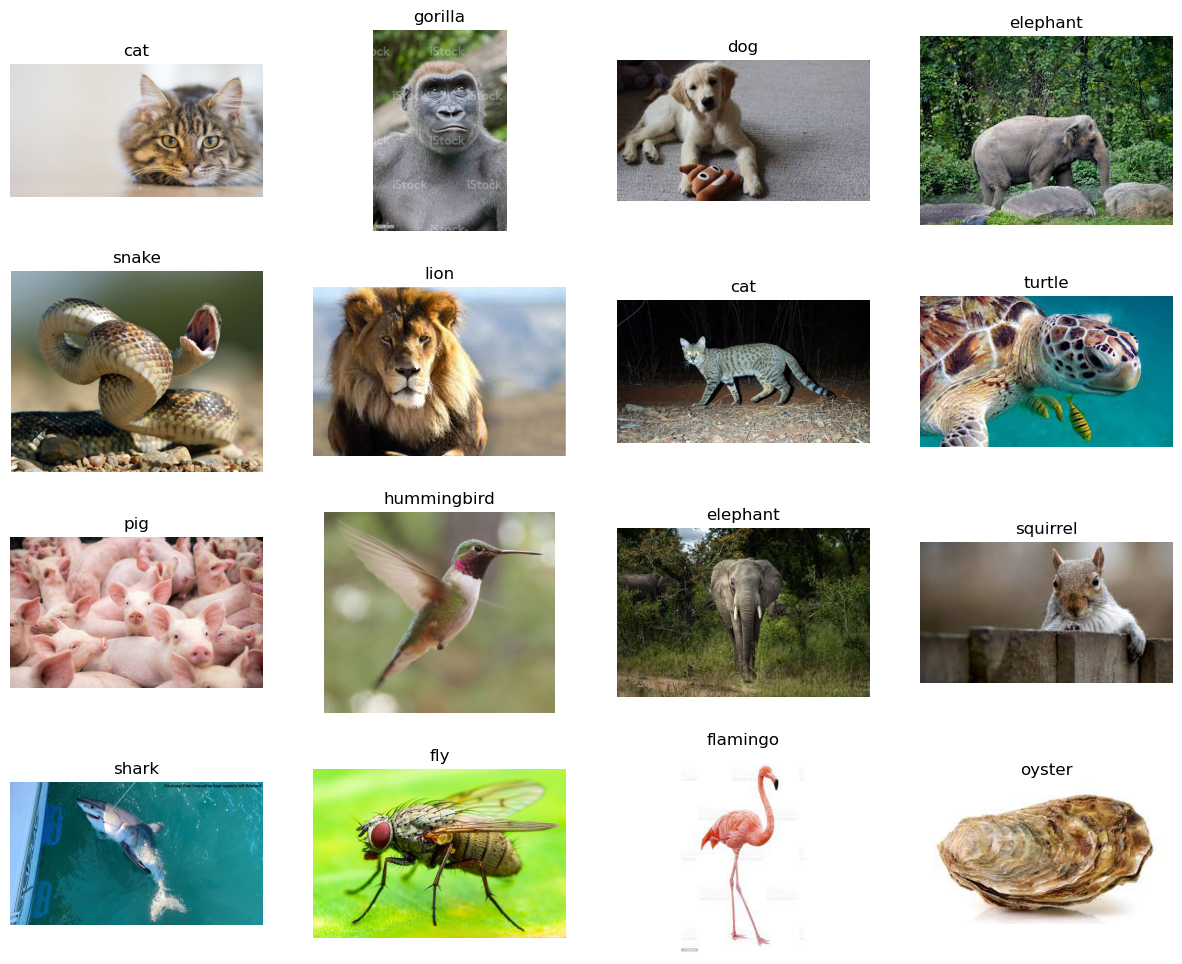

In [ ]:
plt.figure(figsize=(15,12))
for i, row in test_df.sample(n=16).reset_index().iterrows():
    plt.subplot(4,4,i+1)
    image_path = row['imgpath']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["labels"])
    plt.axis('off')
plt.show()

In [ ]:
def get_train_test_val_images(BATCH_SIZE, IMAGE_SIZE):
    generator = ImageDataGenerator(
        preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
    )

    # Split the data into three categories.
    train_images = generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='imgpath',
        y_col='labels',
        target_size=IMAGE_SIZE,
        color_mode='rgb',
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=42,
    )

    val_images = generator.flow_from_dataframe(
        dataframe=valid_df,
        x_col='imgpath',
        y_col='labels',
        target_size=IMAGE_SIZE,
        color_mode='rgb',
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        shuffle=False
    )

    test_images = generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='imgpath',
        y_col='labels',
        target_size=IMAGE_SIZE,
        color_mode='rgb',
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        shuffle=False
    )

    return [train_images, test_images, val_images]

def save_history_in_csv(run_name, file_name):
    epochs = range(1, len(history.history['loss']) + 1)

    keys_of_interest = ['loss', 'accuracy', 'top_k_categorical_accuracy',
                        'val_loss', 'val_accuracy', 'val_top_k_categorical_accuracy', 'lr']

    with open(file_name, mode='w', newline='') as file:
        writer = csv.writer(file)
        header = ['Run', 'Epoch'] + keys_of_interest
        writer.writerow(header)

        for epoch in epochs:
            row_data = [run_name, epoch]
            for key in keys_of_interest:
                row_data.append(history.history[key][epoch - 1])  # Epochs start from 1 but list indices start from 0
            writer.writerow(row_data)

In [ ]:
def get_Resnet50_based_model(set_pretrain_model_to_trainable=False):
    pretrained_model = tf.keras.applications.ResNet50(
        input_shape=(224, 224, 3),
        include_top=False, # we don`t need a pre-trained top layer (output layer)
        weights='imagenet',
        pooling='avg'
    )

    for i, layer in enumerate(pretrained_model.layers):
        pretrained_model.layers[i].trainable = False

    augment = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
        tf.keras.layers.experimental.preprocessing.RandomFlip('vertical'),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.15),
        tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        tf.keras.layers.experimental.preprocessing.RandomContrast(0.15)
    ], name='AugmentationLayer')

    num_classes = len(set(train_images.classes))

    inputs = layers.Input(shape = (224,224,3), name='inputLayer')
    x = augment(inputs)
    pretrain_out = pretrained_model(x, training = False)
    x = layers.Dense(1024)(pretrain_out)
    x = layers.Activation(activation="relu")(x)
    x = layers.Dense(90)(x) #num_classes
    outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x) # mixed_precision need separated Dense and Activation layers
    model = Model(inputs=inputs, outputs=outputs)

    return model

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def get_Resnet50_based_model_2():
    # Create the ResNet model
    pretrained_model = tf.keras.applications.ResNet50(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet',
        pooling='avg'
    )

    for i, layer in enumerate(pretrained_model.layers):
        pretrained_model.layers[i].trainable = False

    num_classes = 90

    # Add dense layers for classification
    x = pretrained_model.output
    x = layers.Dense(1024)(x)
    x = layers.Activation(activation="relu")(x)
    x = layers.Dense(num_classes)(x)
    outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x)

    # Construct model
    model = Model(inputs=pretrained_model.input, outputs=outputs)

    return model

In [ ]:
BATCH_SIZE =  30
IMAGE_SIZE = (224, 224)
train_images, test_images, val_images = get_train_test_val_images(BATCH_SIZE, IMAGE_SIZE)

Found 4320 validated image filenames belonging to 90 classes.
Found 540 validated image filenames belonging to 90 classes.
Found 540 validated image filenames belonging to 90 classes.


In [ ]:
model = get_Resnet50_based_model()

metrics_list = [
    'accuracy',
    TopKCategoricalAccuracy(k=3)
]

# Model compilation
model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=metrics_list
)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 AugmentationLayer (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 activation (Activation)     (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 90)                92250     
                                                             

In [ ]:
# Create an ImageDataGenerator for data augmentation
data_augmentation = ImageDataGenerator(
    rotation_range=20
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)

# Model training with data augmentation
history = model.fit(
    data_augmentation.flow(train_images, batch_size=BATCH_SIZE),
    steps_per_epoch=len(train_images) // BATCH_SIZE,
    validation_data=val_images,
    validation_steps=len(val_images) // BATCH_SIZE,
    epochs=20,
    callbacks=[
        EarlyStopping(monitor="val_loss",
                      patience=3,
                      restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss',
                          factor=0.2,
                          patience=2,
                          mode='min')
    ]
)

In [ ]:
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=70,
    callbacks=[
        EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 3,
                               restore_best_weights = True), # if val loss decreases for 3 epochs in a row, stop training,
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)

Epoch 1/20
144/144 [==============================] - 27s 178ms/step - loss: 3.8089 - accuracy: 0.1745 - top_k_categorical_accuracy: 0.2928 - val_loss: 2.6669 - val_accuracy: 0.3889 - val_top_k_categorical_accuracy: 0.6037 - lr: 1.0000e-04
Epoch 2/20
144/144 [==============================] - 25s 172ms/step - loss: 2.3810 - accuracy: 0.4495 - top_k_categorical_accuracy: 0.6375 - val_loss: 1.8222 - val_accuracy: 0.5519 - val_top_k_categorical_accuracy: 0.7426 - lr: 1.0000e-04
Epoch 3/20
144/144 [==============================] - 25s 173ms/step - loss: 1.7878 - accuracy: 0.5627 - top_k_categorical_accuracy: 0.7435 - val_loss: 1.4487 - val_accuracy: 0.6315 - val_top_k_categorical_accuracy: 0.7944 - lr: 1.0000e-04
Epoch 4/20
144/144 [==============================] - 25s 174ms/step - loss: 1.5039 - accuracy: 0.6280 - top_k_categorical_accuracy: 0.8005 - val_loss: 1.3116 - val_accuracy: 0.6704 - val_top_k_categorical_accuracy: 0.8444 - lr: 1.0000e-04
Epoch 5/20
144/144 [====================

In [ ]:
current_datetime = datetime.datetime.now()
formatted_datetime = current_datetime.strftime("%Y%m%d_%H%M%S")

filename_weights = f"./checkpoints/checkpoint_{formatted_datetime}.h5"
model.save_weights(filename_weights)

filename_history = f"./histories/history_{formatted_datetime}.pkl"
with open(filename_history, 'wb') as file:
    pickle.dump(history.history, file)

run_name = "training_run"
file_name = "./histories/training_history.csv"
save_history_in_csv(run_name, file_name)

In [ ]:
BATCH_SIZES = [30, 60, 90]
LEARNING_RATES = [0.00001, 0.0001, 0.001]
OPTIMIZERS = ['adam', 'RMSprop', 'SGD']

def get_hyperparameters_randomily_combined():
    combinations = list(itertools.product(BATCH_SIZES, LEARNING_RATES, OPTIMIZERS))
    # Shuffle the combinations to randomize the order
    random.shuffle(combinations)
    return combinations

def save_history_in_csv(run_name, file_name, hyperparamters):
    epochs = range(1, len(history.history['loss']) + 1)

    batch_size, learning_rate, optimizer = hyperparameters
    keys_of_interest = ['loss', 'accuracy', 'top_k_categorical_accuracy',
                        'val_loss', 'val_accuracy', 'val_top_k_categorical_accuracy', 'lr']

    with open(file_name, mode='w', newline='') as file:
        writer = csv.writer(file)
        header = ['run', 'epoch', "batch_size", "learning_rate", "optimizer"] + keys_of_interest
        writer.writerow(header)

        for epoch in epochs:
            row_data = [run_name, epoch, batch_size, learning_rate, optimizer]
            for key in keys_of_interest:
                row_data.append(history.history[key][epoch - 1])  # Epochs start from 1 but list indices start from 0
            writer.writerow(row_data)

def initialize_total_results_dict():
    hyperparameters_randomly_combined = get_hyperparameters_randomily_combined()
    hyperparameters = list(hyperparameters_randomly_combined)
    hyperparameters.sort()
    total_results = dict()
    for hyperparamter_combination in hyperparameters:
        total_results[hyperparamter_combination] = list()
    return total_results

def get_model_load_weights():
    model = get_Resnet50_based_model()
    model.load_weights('./checkpoints/baseline/checkpoint_20231203_163956.h5')
    return model


def fine_tune(hyperparameters):
    batch_size, learning_rate, optimizer = hyperparameters

    if optimizer == 'adam':
        optimizer = Adam(learning_rate)
    elif optimizer == 'SGD':
        optimizer = SGD(learning_rate)
    else:
        optimizer = RMSprop(learning_rate)

    model = get_model_load_weights()
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=metrics_list
    )

    history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=30,
    callbacks=[
            EarlyStopping(monitor = "val_loss",
                                   patience = 5,
                                   restore_best_weights = True)
        ]
    )

    del model

    return history

In [ ]:
def extract_hyperparams(key):
    string_data = str(key)
    values = string_data[1:-1].split(',')
    batch_size = int(values[0])
    learning_rate = float(values[1])
    optimizer = values[2].strip().strip("'")
    return [batch_size, learning_rate, optimizer]

def get_df_total_results_for_run(total_results, RUN_NUMBER):
    total_df = pd.DataFrame()
    for key in total_results.keys():
        if total_results[key]:
            results = total_results[key]
            batch_size, learning_rate, optimizer = extract_hyperparams(key)
            df = pd.DataFrame(results[0].history)
            df['run_number'] = RUN_NUMBER

            num_epochs = len(df)
            df['epoch'] = range(1, num_epochs + 1)

            df['batch_size'] = batch_size
            df['learning_rate'] = learning_rate
            df['optimizer'] = optimizer

            reordered_columns = ['run_number', 'epoch', 'batch_size', 'learning_rate', 'optimizer', 'loss', 'accuracy', 'top_k_categorical_accuracy', 'val_loss', 'val_accuracy', 'val_top_k_categorical_accuracy']
            df = df[reordered_columns]
            total_df = pd.concat([total_df, df], ignore_index=True)
    return total_df

def save_df_to_local(df, RUN_NUMBER):
    file_name = f"./results/run_2_{RUN_NUMBER}.csv"
    df.to_csv(file_name, index=False)


In [ ]:
### THE ACTUAL FINE TUNING IS HERE ###

for RUN_NUMBER in range(1, 6):
    total_results = initialize_total_results_dict()

    hyperparameters_randomly_combined = get_hyperparameters_randomily_combined()
    for hyperparameters in hyperparameters_randomly_combined: #generates 27 combinations
        batch_size, learning_rate, optimizer = hyperparameters
        results = fine_tune(hyperparameters)
        total_results[hyperparameters].append(results)

    total_df = get_df_total_results_for_run(total_results, RUN_NUMBER)
    save_df_to_local(total_df, RUN_NUMBER)

### THE ACTUAL FINE TUNING IS HERE ###

Epoch 1/30
  2/144 [..............................] - ETA: 17s - loss: 0.5997 - accuracy: 0.8333 - top_k_categorical_accuracy: 0.9417 

2023-12-12 21:28:40.684492: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


144/144 [==============================] - 27s 178ms/step - loss: 0.5560 - accuracy: 0.8574 - top_k_categorical_accuracy: 0.9493 - val_loss: 1.0442 - val_accuracy: 0.7222 - val_top_k_categorical_accuracy: 0.8593 - lr: 1.0000e-04
Epoch 2/30
144/144 [==============================] - 25s 173ms/step - loss: 0.5320 - accuracy: 0.8616 - top_k_categorical_accuracy: 0.9560 - val_loss: 1.0140 - val_accuracy: 0.7185 - val_top_k_categorical_accuracy: 0.8778 - lr: 1.0000e-04
Epoch 3/30
144/144 [==============================] - 25s 173ms/step - loss: 0.4724 - accuracy: 0.8766 - top_k_categorical_accuracy: 0.9697 - val_loss: 0.9925 - val_accuracy: 0.7259 - val_top_k_categorical_accuracy: 0.8685 - lr: 1.0000e-04
Epoch 4/30
144/144 [==============================] - 25s 172ms/step - loss: 0.4723 - accuracy: 0.8762 - top_k_categorical_accuracy: 0.9630 - val_loss: 1.0502 - val_accuracy: 0.7315 - val_top_k_categorical_accuracy: 0.8537 - lr: 1.0000e-04
Epoch 5/30
144/144 [==============================]

In [ ]:
### FINE TUNING PART ENDS HERE ###

In [ ]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

In [ ]:
y_true = test_images.classes
y_pred = np.argmax(model.predict(test_images), axis = 1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=test_images.class_indices.keys()))

In [ ]:
classes = dict(zip(test_images.class_indices.values(), test_images.class_indices.keys()))
Predictions = pd.DataFrame({"Image Index" : list(range(len(test_images.labels))),
                            "Test Labels" : test_images.labels,
                            "Test Classes" : [classes[i] for i in test_images.labels],
                            "Prediction Labels" : y_pred,
                            "Prediction Classes" : [classes[i] for i in y_pred],
                            "Path": test_images.filenames,
                            "Prediction Probability" : [x for x in np.asarray(tf.reduce_max(model.predict(test_images), axis = 1))]
                           })
Predictions.head(8)

In [ ]:
plt.figure(figsize=(20,20))
for i, row in Predictions[Predictions["Test Labels"] != Predictions["Prediction Labels"]].sort_values("Prediction Probability").tail(20).reset_index().iterrows():
    plt.subplot(5,4,i+1)
    image_path = row['Path']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f'TRUE: {row["Test Classes"]} | PRED: {row["Prediction Classes"]}', fontsize=8)
    plt.axis('off')

plt.show()